In [86]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import cpi
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50

conn = sqlite3.connect('data\im.db')

In [87]:
df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_names = df['name'].values

movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
directors = pd.read_sql_query("SELECT * FROM directors", conn)
known_for = pd.read_sql_query("SELECT * FROM known_for", conn)
movie_akas = pd.read_sql_query("SELECT * FROM movie_akas", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)
principals = pd.read_sql_query("SELECT * FROM principals", conn)
writers = pd.read_sql_query("SELECT * FROM writers", conn)


In [88]:
info = pd.read_csv("data/rt.movie_info.tsv", sep='\t',header=0, encoding='ISO-8859-1')
reviews = pd.read_csv("data/rt.reviews.tsv", sep='\t',header=0, encoding='ISO-8859-1')
gross = pd.read_csv("data/bom.movie_gross.csv",header=0, encoding='ISO-8859-1') 
movies = pd.read_csv("data/tmdb.movies.csv",header=0, encoding='ISO-8859-1') 
budget = pd.read_csv("data/tn.movie_budgets.csv",header=0, encoding='ISO-8859-1') 


In [89]:
gross['foreign_gross'] = gross['foreign_gross'].fillna(0)
gross['foreign_gross'] = pd.to_numeric(gross['foreign_gross'], errors='coerce')
gross['gross'] = gross['foreign_gross'] + gross['domestic_gross']

In [90]:
# create new column in first dataframe that extracts the year from release_date
movies['theater_date'] = pd.to_datetime(movies['release_date']).dt.year

# merge the two dataframes on original_title and theater_date
merged_movies = pd.merge(movies, movie_basics, left_on=['original_title', 'theater_date'], right_on=['original_title', 'start_year'])

In [91]:
merged_movies = merged_movies.drop_duplicates(subset='title', keep=False)

In [92]:
movies_gross = pd.merge(merged_movies, budget, left_on='title', right_on='movie')

In [93]:
movies_gross['worldwide_gross_int'] = movies_gross['worldwide_gross'].apply(lambda x: int(x.replace(",", "").replace("$", "")))
movies_gross['production_budget_int'] = movies_gross['production_budget'].apply(lambda x: int(x.replace(",", "").replace("$", "")))

In [94]:
movies_gross['profit'] =  (movies_gross['worldwide_gross_int'] - movies_gross['production_budget_int'])

In [95]:
movies_gross['release_date_x'] = pd.to_datetime(movies_gross['release_date_x'])

In [96]:
movies_gross['profit_adjusted'] = movies_gross.apply(lambda row: cpi.inflate(row['profit'],row['release_date_x'].year), axis=1)

In [97]:
movies_gross = movies_gross.dropna(subset=['genres'])
movies_gross = movies_gross.drop_duplicates(subset='title')
movies_gross = movies_gross[movies_gross['profit'] <= 1000000000]

In [98]:

movies_gross_negative = movies_gross[movies_gross['profit'] < 0]
movies_gross_positive = movies_gross[movies_gross['profit'] > 0]

In [99]:
movies_gross_positive = movies_gross_positive.assign(genres = movies_gross_positive['genres'].str.split(','))
movies_gross_positive = movies_gross_positive.explode('genres')
profit_by_genre = movies_gross_positive.groupby('genres')['profit_adjusted'].sum().reset_index()
max_by_genre = movies_gross_positive.groupby('genres')['profit_adjusted'].max().reset_index()

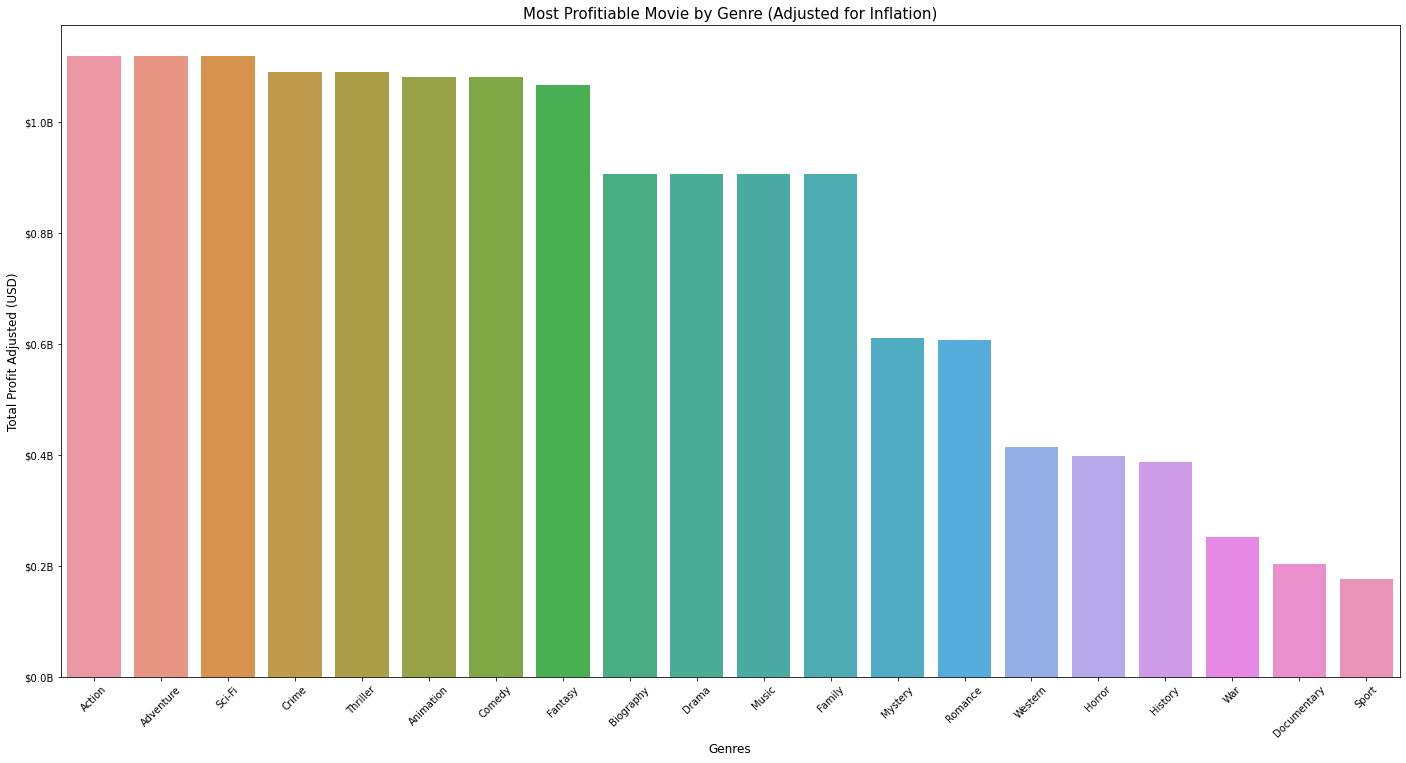

In [100]:
import matplotlib.ticker as ticker

max_by_genre = max_by_genre.sort_values(by='profit_adjusted',ascending=False)
fig, ax = plt.subplots(figsize=(24,12))
sns.barplot(x='genres', y='profit_adjusted', data=max_by_genre, ax=ax)

formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Genres", size=12)
ax.set_ylabel("Total Profit Adjusted (USD)", size=12)
ax.set_title("Most Profitiable Movie by Genre (Adjusted for Inflation)", size=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('max_by_genre.jpg', format='jpg')

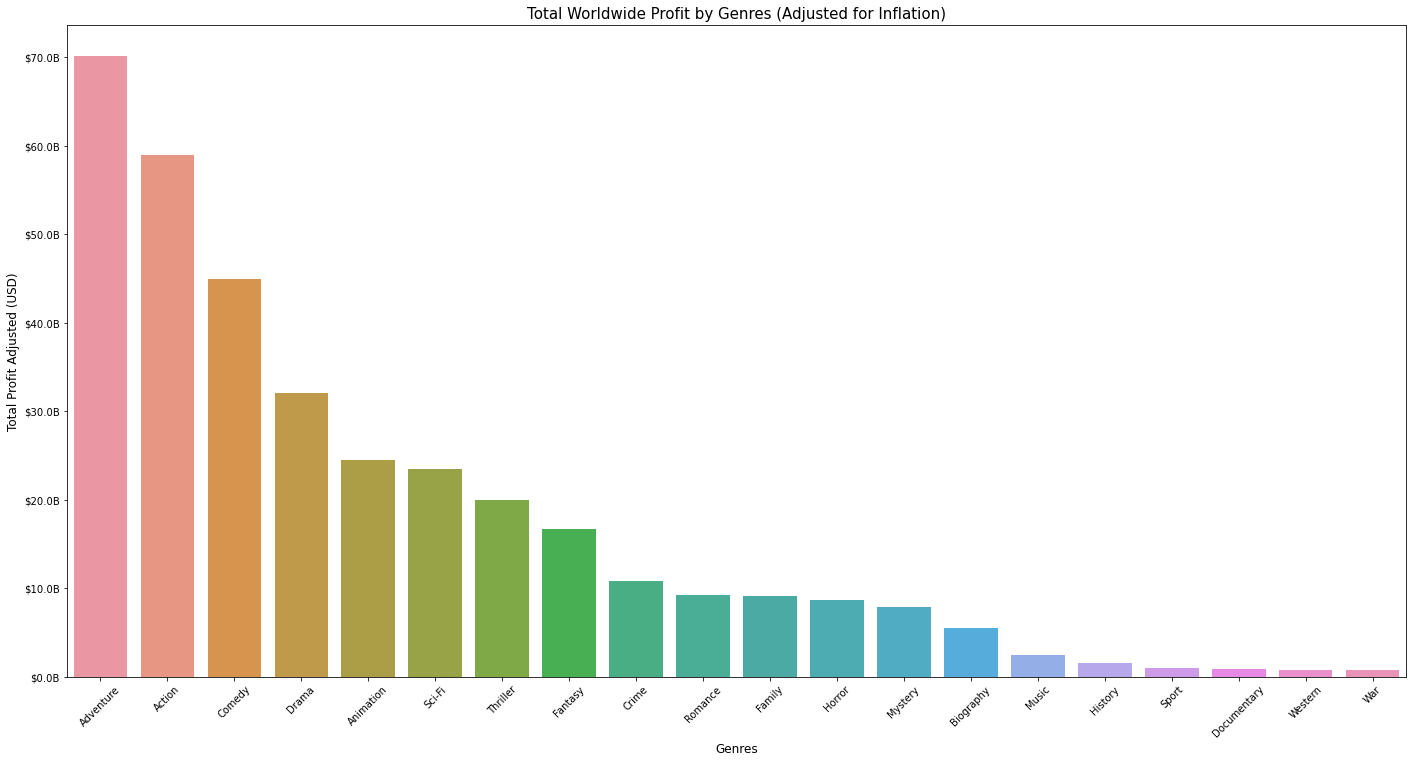

In [101]:
import matplotlib.ticker as ticker

profit_by_genre = profit_by_genre.sort_values(by='profit_adjusted',ascending=False)
fig, ax = plt.subplots(figsize=(24,12))
sns.barplot(x='genres', y='profit_adjusted', data=profit_by_genre, ax=ax)

formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Genres", size=12)
ax.set_ylabel("Total Profit Adjusted (USD)", size=12)
ax.set_title("Total Worldwide Profit by Genres (Adjusted for Inflation)", size=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('profit_by_genre.jpg', format='jpg')

In [102]:
movies_gross_negative = movies_gross_negative.assign(genres = movies_gross_negative['genres'].str.split(','))
movies_gross_negative = movies_gross_negative.explode('genres')
profit_by_genre_negative = movies_gross_negative.groupby('genres')['profit_adjusted'].sum().reset_index()

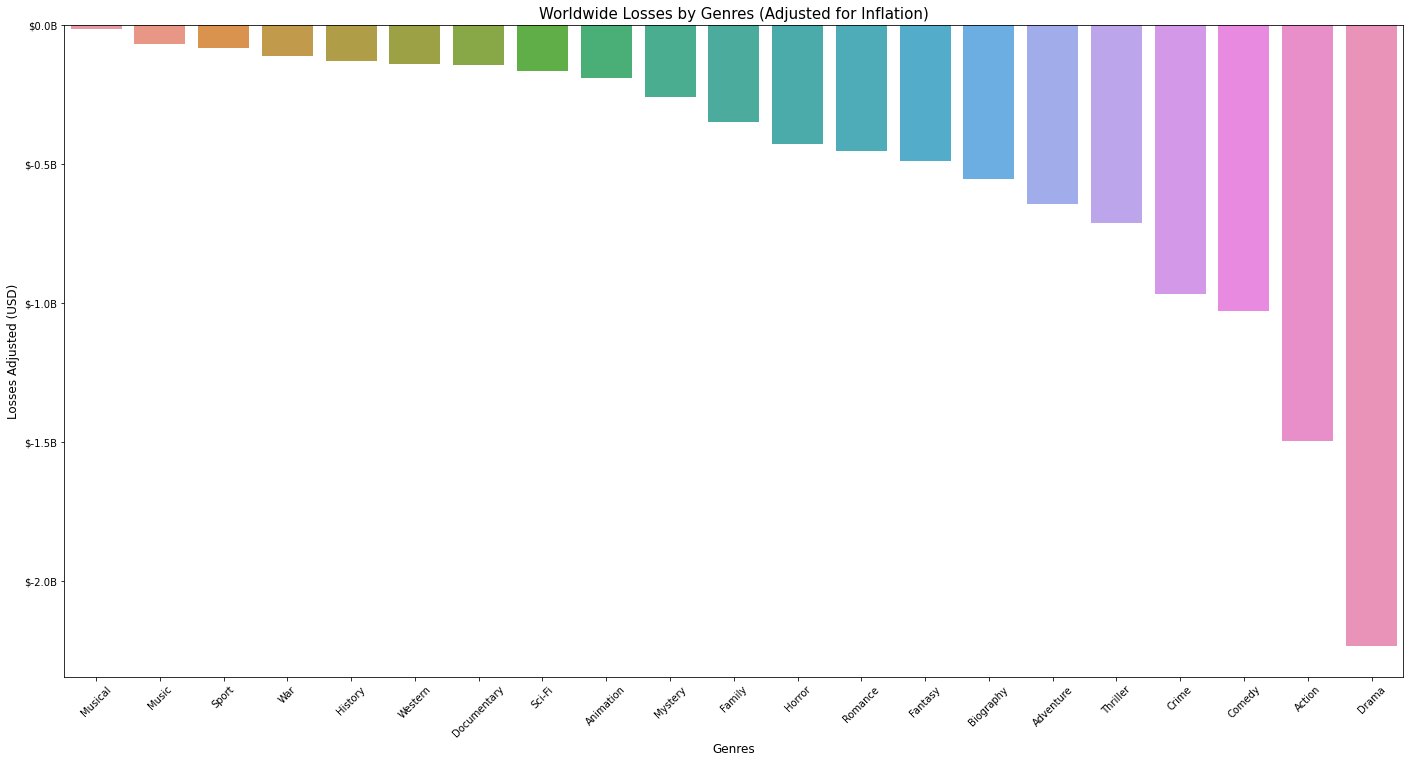

In [103]:
import matplotlib.ticker as ticker

Losses_by_genre = profit_by_genre_negative.sort_values(by='profit_adjusted',ascending=False)
fig, ax = plt.subplots(figsize=(24,12))
sns.barplot(x='genres', y='profit_adjusted', data=Losses_by_genre, ax=ax)

formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Genres", size=12)
ax.set_ylabel("Losses Adjusted (USD)", size=12)
ax.set_title("Worldwide Losses by Genres (Adjusted for Inflation)", size=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('Losses_by_genre.jpg', format='jpg')


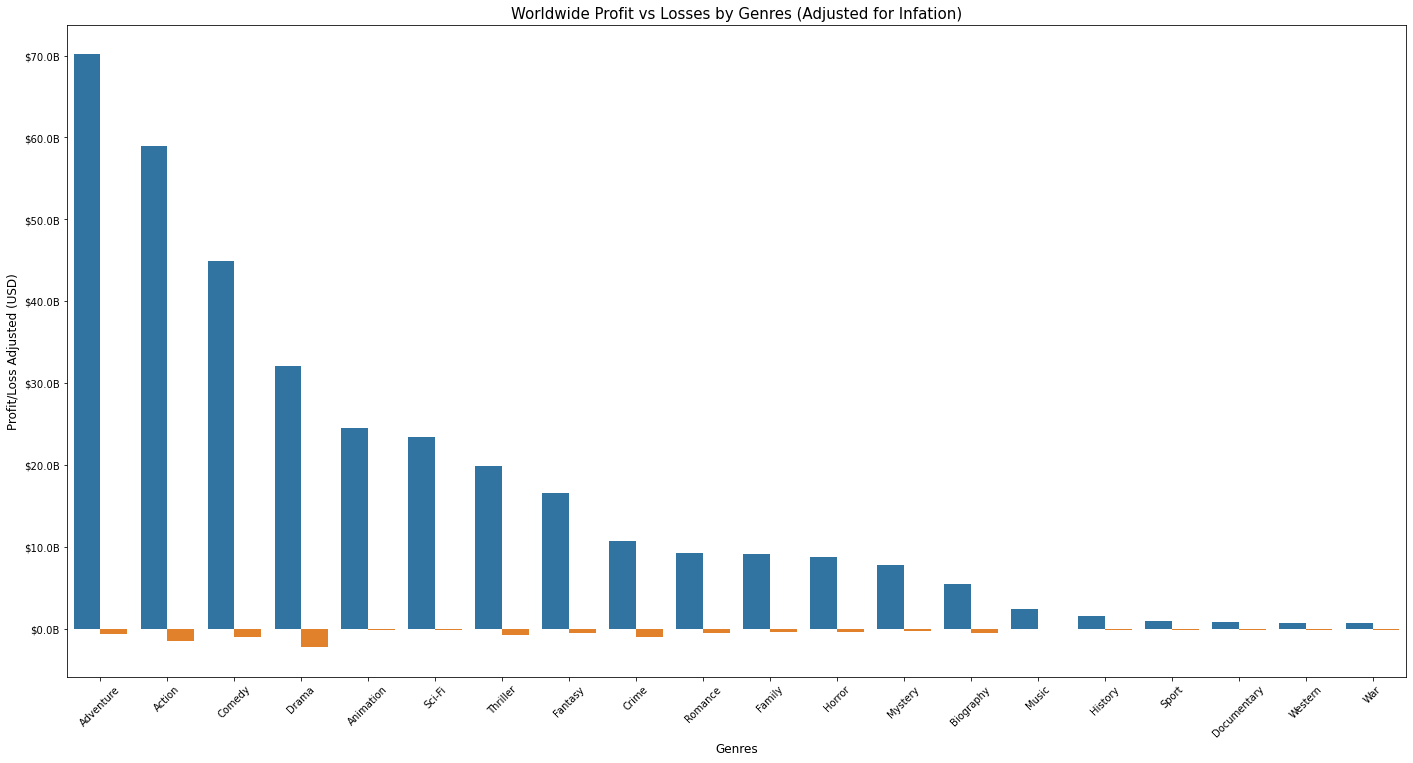

In [104]:
# Combine the two dataframes into a single dataframe
df = pd.merge(profit_by_genre, Losses_by_genre, on='genres', suffixes=('_profit', '_loss'))

# Use the melt() function to reshape the dataframe
df_melt = df.melt(id_vars='genres', value_vars=['profit_adjusted_profit', 'profit_adjusted_loss'], var_name='Profit/Loss', value_name='Profit/Loss_adjusted')

# Create a new figure and axes for the chart
fig, ax = plt.subplots(figsize=(24,12))

# Use seaborn's barplot() function to create a stacked bar chart
sns.barplot(x='genres', y='Profit/Loss_adjusted', hue='Profit/Loss', data=df_melt, ax=ax)

# Set the labels and title
ax.set_xlabel("Genres", size=12)
ax.set_ylabel("Profit/Loss Adjusted (USD)", size=12)
ax.set_title("Worldwide Profit vs Losses by Genres (Adjusted for Infation)", size=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend().set_visible(False)

# format the y axis
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter)

plt.savefig('ProfitvsLosses_by_genre_v2.jpg', format='jpg')

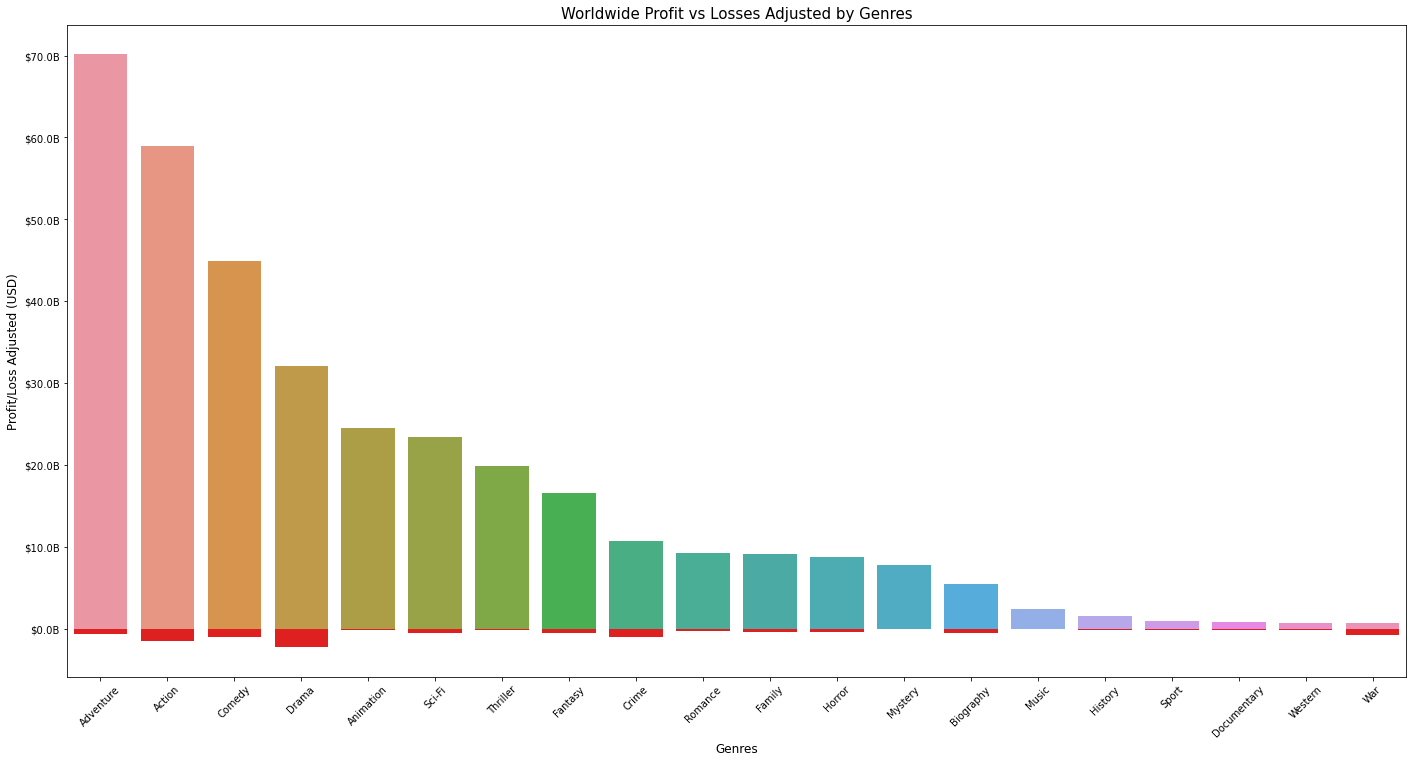

In [105]:
# Create a new DataFrame that contains both the profit and loss values for each genre
genre_profit_loss = pd.DataFrame({'genres':profit_by_genre['genres'], 'profit':profit_by_genre['profit_adjusted'], 'loss':profit_by_genre_negative['profit_adjusted']})
# Sort the DataFrame by the profit values in descending order
genre_profit_loss = genre_profit_loss.sort_values(by='profit',ascending=False)


# Create a new figure and axes for the chart
fig, ax = plt.subplots(figsize=(24,12))

# plot the profit bar
sns.barplot(x='genres', y='profit', data=genre_profit_loss, label='Profit', ax=ax)

# plot the loss bar
sns.barplot(x='genres', y='loss', data=genre_profit_loss, label='Loss',color='red',ax=ax)


# Set the labels and title
ax.set_xlabel("Genres", size=12)
ax.set_ylabel("Profit/Loss Adjusted (USD)", size=12)
ax.set_title("Worldwide Profit vs Losses Adjusted by Genres", size=15)
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend().set_visible(False)

# format the y axis
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter)

plt.savefig('ProfitvsLosses_by_genre.jpg', format='jpg')
